In [7]:
!pip install nibabel opencv-python tensorflow
import os
import cv2
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence


Defaulting to user installation because normal site-packages is not writeable


In [8]:
IMG_SIZE = 128

def load_volume(path):
    return nib.load(path).get_fdata()

def preprocess_slice(img, mask):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)
    mask = (mask > 0).astype(np.float32)
    
    return img, mask


In [9]:
class BraTSDataset(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        imgs, masks = [], []
        
        for i in range(self.batch_size):
            vol = load_volume(self.image_paths[idx*self.batch_size + i])
            seg = load_volume(self.mask_paths[idx*self.batch_size + i])

            slice_idx = vol.shape[2] // 2
            img, mask = preprocess_slice(vol[:,:,slice_idx], seg[:,:,slice_idx])
            
            imgs.append(img[...,None])
            masks.append(mask[...,None])

        return np.array(imgs), np.array(masks)


In [10]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def unet():
    inputs = Input((IMG_SIZE, IMG_SIZE, 1))

    c1 = Conv2D(32,3,activation='relu',padding='same')(inputs)
    c1 = Conv2D(32,3,activation='relu',padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(64,3,activation='relu',padding='same')(p1)
    c2 = Conv2D(64,3,activation='relu',padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(128,3,activation='relu',padding='same')(p2)
    c3 = Conv2D(128,3,activation='relu',padding='same')(c3)

    u1 = UpSampling2D()(c3)
    u1 = Concatenate()([u1, c2])
    c4 = Conv2D(64,3,activation='relu',padding='same')(u1)

    u2 = UpSampling2D()(c4)
    u2 = Concatenate()([u2, c1])
    c5 = Conv2D(32,3,activation='relu',padding='same')(u2)

    outputs = Conv2D(1,1,activation='sigmoid')(c5)

    return Model(inputs, outputs)


In [11]:
import tensorflow as tf

def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2.*intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    return (intersection + 1) / (union + 1)


In [15]:
import kagglehub

DATASET_PATH = kagglehub.dataset_download(
    "dschettler8845/brats-2021-task1"
)
image_paths = []
mask_paths = []

import tarfile
import os

for file in os.listdir(DATASET_PATH):
    if file.endswith(".tar"):
        tar_path = os.path.join(DATASET_PATH, file)
        print("Extracting:", file)
        with tarfile.open(tar_path) as tar:
            tar.extractall(path=DATASET_PATH)


for patient in os.listdir(DATASET_PATH):
    patient_dir = os.path.join(DATASET_PATH, patient)

    if os.path.isdir(patient_dir):
        files = os.listdir(patient_dir)

        flair = [f for f in files if f.endswith("_flair.nii.gz")][0]
        seg   = [f for f in files if f.endswith("_seg.nii.gz")][0]

        image_paths.append(os.path.join(patient_dir, flair))
        mask_paths.append(os.path.join(patient_dir, seg))

from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    image_paths,
    mask_paths,
    test_size=0.2,
    random_state=42
)

train_dataset = BraTSDataset(train_imgs, train_masks, batch_size=4)
val_dataset   = BraTSDataset(val_imgs, val_masks, batch_size=4)



Extracting: BraTS2021_00495.tar
Extracting: BraTS2021_Training_Data.tar
Extracting: BraTS2021_00621.tar


In [16]:
print(DATASET_PATH)
print(os.listdir(DATASET_PATH))


/home/suraj/.cache/kagglehub/datasets/dschettler8845/brats-2021-task1/versions/1
['BraTS2021_01310', 'BraTS2021_00557', 'BraTS2021_00081', 'BraTS2021_01144', 'BraTS2021_01280', 'BraTS2021_01615', 'BraTS2021_00077', 'BraTS2021_01196', 'BraTS2021_01063', 'BraTS2021_00263', 'BraTS2021_01261', 'BraTS2021_00167', 'BraTS2021_00616', 'BraTS2021_00594', 'BraTS2021_00405', 'BraTS2021_01145', 'BraTS2021_01509', 'BraTS2021_01386', 'BraTS2021_00300', 'BraTS2021_01099', 'BraTS2021_00288', 'BraTS2021_00451', 'BraTS2021_00705', 'BraTS2021_01217', 'BraTS2021_00414', 'BraTS2021_00238', 'BraTS2021_01011', 'BraTS2021_00243', 'BraTS2021_00512', 'BraTS2021_01450', 'BraTS2021_01367', 'BraTS2021_00406', 'BraTS2021_01200', 'BraTS2021_01567', 'BraTS2021_00170', 'BraTS2021_01656', 'BraTS2021_01513', 'BraTS2021_00469', 'BraTS2021_00162', 'BraTS2021_00555', 'BraTS2021_01245', 'BraTS2021_01511', 'BraTS2021_01247', 'BraTS2021_00203', 'BraTS2021_01007', 'BraTS2021_01205', 'BraTS2021_00768', 'BraTS2021_00240', 'BraTS

In [17]:
model = unet()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[dice_coef, iou]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


/home/suraj/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-12-26 21:40:42.789097: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


250/250 ━━━━━━━━━━━━━━━━━━━━ 168s 662ms/step - dice_coef: 0.2250 - iou: 0.1302 - loss: 0.0966 - val_dice_coef: 0.3300 - val_iou: 0.2008 - val_loss: 0.0629
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 650ms/step - dice_coef: 0.4661 - iou: 0.3143 - loss: 0.0551 - val_dice_coef: 0.5964 - val_iou: 0.4358 - val_loss: 0.0448
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 158s 632ms/step - dice_coef: 0.5813 - iou: 0.4215 - loss: 0.0458 - val_dice_coef: 0.5989 - val_iou: 0.4364 - val_loss: 0.0485
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 157s 626ms/step - dice_coef: 0.6579 - iou: 0.5014 - loss: 0.0370 - val_dice_coef: 0.6999 - val_iou: 0.5441 - val_loss: 0.0301
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 626ms/step - dice_coef: 0.6738 - iou: 0.5186 - loss: 0.0356 - val_dice_coef: 0.7192 - val_iou: 0.5687 - val_loss: 0.0279
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 156s 626ms/step - dice_coef: 0.7129 - iou: 0.5629 - loss: 0.0304 - val_dice_coef: 0.7449 - val_iou: 0.5997 - val_loss: 0.0273
Epoch 7/10
250/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


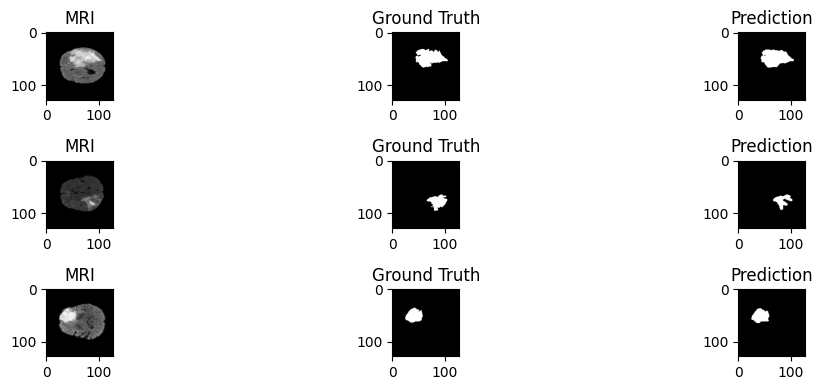

In [18]:
imgs, masks = val_dataset[0]
preds = model.predict(imgs)

plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title("MRI")

    plt.subplot(3,3,3*i+2)
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(3,3,3*i+3)
    plt.imshow(preds[i].squeeze()>0.5, cmap='gray')
    plt.title("Prediction")
plt.tight_layout()
plt.show()
